# Ridge-regression (Regression + regularization) mini-tutorial

# Background

In this set of exercises we will try to predict the neural activity from videos of animal behavior using ridge-regression.  The data we will use come from a larger dataset published here: https://science.sciencemag.org/content/364/6437/eaav7893.  For the data here, the mouse was not doing a task, and was free to run and whisk and groom as it pleased. In the meantime there was random noise shown on the screen in front of the mouse.

The neural data consists of the activity of excitatory neurons in visual cortex recorded using two-photon calcium imaging. For these exercises it has been pre-processed.  There were originally 5439 neurons, but here we have reduced that to the top 256 principal components sampled at 1Hz.

The behavioral data was recorded for the same period. While the mouse was on the microscope, we captured its face on video and took the top 500 PCs of the motion energy of this video data, sampled at 1Hz. 

This particular group of neurons have been classified as NOT stimulus-selective, so we are interested in understanding what they are doing. The motivation for this regression analysis is to investigate whether the neural activity is explained by mouse behavior.


# 0) Set up python packages and load data

In [1]:
# This cell imports all the functions and data we need.
import os # os stands for "operating system" and includes read/write routines etc. 
import numpy as np # by far the most used library for everyday computation
from scipy import io # this is for importing Matlab data files
from scipy import stats # here we import a whole sub-library of stats functions
from scipy.ndimage import gaussian_filter # here we import a single function for gaussian_filtering
from sklearn.decomposition import PCA # check out all the other dimensionality reduction methods in "decomposition"
from matplotlib import pyplot as plt # all of our plotting is done with plt
from scipy.stats import zscore
import urllib
%matplotlib inline 

# download 2-photon data

with urllib.request.urlopen('https://github.com/kbonnen/NeuromatchTeachingDemo/raw/master/teaching-demo-data.npy') as response:
    with open('teaching-demo-data.npy','wb') as f:
        f.write(response.read())

data = np.load('teaching-demo-data.npy',allow_pickle=True).item()

# Extract the data into variables
neural_reduced = zscore(data['neural_reduced'], axis=1) # 2-photon neural activity with mean 0 and standard deviation, collected at 3Hz
behavior_reduced = data['behavior_reduced'] # video of the mouse's face during behavior projected onto the top 500 principal components
del data


# Examine the data a bit:
print('neural data: ' + str(neural_reduced.shape[0]) + ' neural components x ' + str(neural_reduced.shape[1]) + ' time points (seconds)')
print('behavioral data: ' + str(behavior_reduced.shape[0]) + ' behavioral components x ' + str(behavior_reduced.shape[1]) + ' time points (seconds)')


neural data: 256 neural components x 3333 time points (seconds)
behavioral data: 500 behavioral components x 3333 time points (seconds)


# 1) Prediction of Neural principal components using Behavioral principal components

# a) Split the data into train and test sets

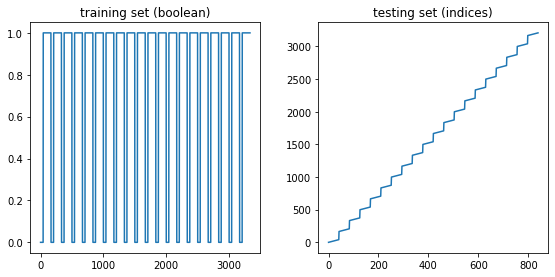

In [2]:
# Split the data into train and test sets
# *** use interleaved segments ***
nsegs = 20
nt = neural_reduced.shape[1]
nlen  = nt/nsegs
ninds = np.linspace(0,nt-nlen,nsegs).astype(int)
itest = (ninds[:,np.newaxis] + np.arange(0,nlen*0.25,1,int)).flatten()
itrain = np.ones(nt, np.bool)
itrain[itest] = 0

fig=plt.figure(figsize=(8,4))
ax = fig.add_axes([0,.05,.4,.8])
ax.plot(itrain)
ax.set_title("training set (boolean)")

ax = fig.add_axes([0.5,.05,.4,.8])
ax.plot(itest)
ax.set_title("testing set (indices)")
plt.show()


Q: What is the motivation for splitting the data into training and test sets by segments in the manner illustrated above? 

A: Neural data points are correlated in time on slow timescales, so nearby points are correlated. You want your training and testing sets to be as independent as possible to minimize the chance that you are overfitting to the training set. For example, here we have placed 75% of the data in training and 25% in test. Those slower timescale correlations could lead to overfitting if I took the *first* 75% of the data in training and the *last* 25% of the data in test. It's better to take these separated chunks throughout the data.

## b) Linear Regression

Now use linear regression to perform the prediction, predict $Y$ using $X$:

$$ A = (X_\text{train}X_\text{train}^\top)^{-1} (X_\text{train} Y_\text{train}^\top)$$

where $X$ is the reduced behavioral data and $Y$ is the reduced neural data

Then the prediction is:

$$ \hat Y_\text{test} = A^\top X_\text{test} $$

In [3]:
XXt = np.matmul(behavior_reduced[:,itrain], behavior_reduced[:,itrain].T)  # SOLUTION
XYt = np.matmul(behavior_reduced[:,itrain], neural_reduced[:,itrain].T)  # SOLUTION
A = np.linalg.solve(XXt, XYt )

Yhat_linear = np.matmul(A.T, behavior_reduced[:,itest])  # SOLUTION
Yhat_train_linear = np.matmul(A.T, behavior_reduced[:,itrain]) # SOLUTION


# Calculate the proportion of variance explained.
varexp_linear = 1 - ((Yhat_linear - neural_reduced[:,itest])**2).sum(axis=1)/(neural_reduced[:,itest]**2).sum(axis=1)

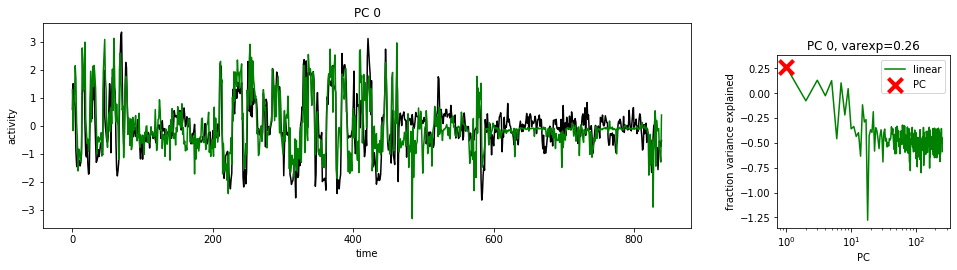

In [4]:
# plot of principal component activity and variance explained

fig=plt.figure(figsize=(12,3))

ipc = 0 ### which neural PC to plot

ax = fig.add_axes([0.05,.05,.75,.95])
ax.plot(neural_reduced[ipc,itest],color=[0,0,0])
ax.plot(Yhat_linear[ipc], color=[0,.5,0])
ax.set_title('PC %d'%ipc)
ax.set_xlabel('time')
ax.set_ylabel('activity')

ax = fig.add_axes([0.9,.05, .2, .8])
ax.scatter(ipc+1, varexp_linear[ipc],marker='x',color='r',s=200, lw=4, zorder=10)
ax.semilogx(np.arange(1,varexp_linear.size+1), varexp_linear, color=[0,.5,0])
ax.legend(['linear','PC'])
ax.set_xlabel('PC')
ax.set_ylabel('fraction variance explained')
ax.set_title('PC %d, varexp=%0.2f'%(ipc,varexp_linear[ipc]))
plt.show()

## c) Ridge Regression

Now let's regularize the linear regression using the L2-norm (a.k.a. ridge regression):

$$ A = (X_\text{train}X_\text{train}^\top + \lambda I)^{-1} (X_\text{train} Y_\text{train}^\top)$$

Then the prediction is still:

$$ \hat Y_\text{test} = A^\top X_\text{test} $$


In [5]:
XXt = np.matmul(behavior_reduced[:,itrain], behavior_reduced[:,itrain].T)  # SOLUTION
lam = 1e6 # regularizer # SOLUTION
XXt += lam*np.eye(behavior_reduced.shape[0]) # SOLUTION
XYt = np.matmul(behavior_reduced[:,itrain], neural_reduced[:,itrain].T)  
A = np.linalg.solve(XXt, XYt )

Yhat_ridge = np.matmul(A.T, behavior_reduced[:,itest])  # SOLUTION
Yhat_train_ridge = np.matmul(A.T, behavior_reduced[:,itrain]) # SOLUTION

# Calculate the proportion of variance explained.
varexp_ridge = 1 - ((Yhat_ridge - neural_reduced[:,itest])**2).sum(axis=1)/(neural_reduced[:,itest]**2).sum(axis=1)


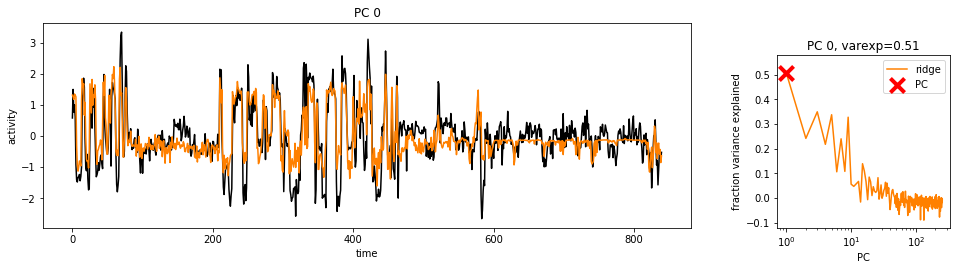

In [6]:
# plot of principal component activity and variance explained

fig=plt.figure(figsize=(12,3))

ipc = 0 ### which PC to plot

ax = fig.add_axes([0.05,.05,.75,.95])
ax.plot(neural_reduced[ipc,itest],color=[0,0,0])
ax.plot(Yhat_ridge[ipc], color=[1,.5,0])
ax.set_title('PC %d'%ipc)
ax.set_xlabel('time')
ax.set_ylabel('activity')

ax = fig.add_axes([0.9,.05, .2, .8])
ax.scatter(ipc+1, varexp_ridge[ipc],marker='x',color='r',s=200, lw=4, zorder=10)
ax.semilogx(np.arange(1,varexp_ridge.size+1), varexp_ridge, color=[1,.5,0])
ax.legend(['ridge','PC'])
ax.set_xlabel('PC')
ax.set_ylabel('fraction variance explained')
ax.set_title('PC %d, varexp=%0.2f'%(ipc,varexp_ridge[ipc]))
plt.show()

## d) Compare Linear Regression to Ridge Regression 

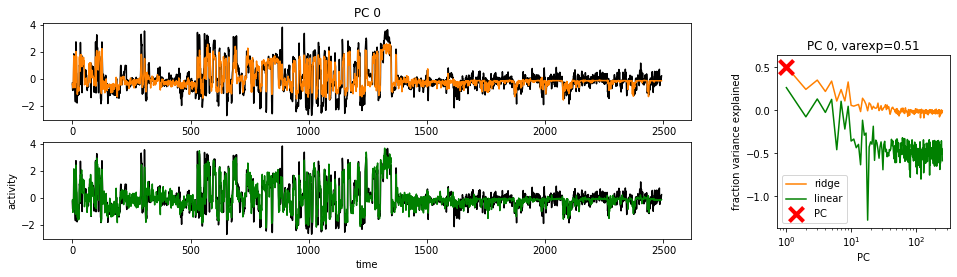

In [7]:
# plot of principal component activity from the training set and variance explained

fig=plt.figure(figsize=(12,3))

ipc = 0 ### which PC to plot

# Plot Yhat for the training set for ridge regression
ax = fig.add_axes([0.05,.55,.75,.45])
ax.plot(neural_reduced[ipc,itrain],color=[0,0,0])
ax.plot(Yhat_train_ridge[ipc], color=[1,.5,0])
ax.set_title('PC %d'%ipc)

# Plot Yhat for the training set for linear regression
ax = fig.add_axes([0.05,0,.75,.45])
ax.plot(neural_reduced[ipc,itrain],color=[0,0,0])
ax.plot(Yhat_train_linear[ipc],  color=[0.,.5,0])
ax.set_xlabel('time')
ax.set_ylabel('activity')

# Plot the variance explained
ax = fig.add_axes([0.9,.05, .2, .8])
ax.scatter(ipc+1, varexp_ridge[ipc],marker='x',color='r',s=200, lw=4, zorder=10)
ax.semilogx(np.arange(1,varexp_ridge.size+1), varexp_ridge, color=[1,.5,0])
ax.semilogx(np.arange(1,varexp_linear.size+1), varexp_linear, color=[0.,.5,0])
ax.set_xlabel('PC')
ax.set_ylabel('fraction variance explained')
ax.set_title('PC %d, varexp=%0.2f'%(ipc,varexp_ridge[ipc]))
ax.legend(['ridge','linear','PC'])
plt.show()


Q: Do you see evidence of overfitting for the linear solution? Where?

A: The plots on the left show the fit to the first PC for the training data.  Notice that the fit from linear regression (green trace, lower) seems to match the ground truth (black trace) better than the ridge regression (orange trace, upper). At the same time the fraction of variance explained in the test data (plotted on the right) is better for ridge-regression than for linear regression.  This suggests that the use of linear regression results in a solution which is overfitting the training data and thus generalizing poorly to the testing set.